# Idea

We will start with the ~~celebrity~~ (MINST for now!) faces dataset and then go on from there.

Broad idea:
1. Figure out how to get the ~~celebrity~~ images and then noise them.  
    a. This is probably relatively easy to do with pytortch as we can get the ~~celebrity~~ images from there.

    b. Adding noise too should be relatively simple.

    c. ~~We should resize the images, as they are very small for us to be able to just use the 'default' U-net architecture. (There is almost surely a way to make the U-net work for smaller images, but if we stick to the well-known implementation, it also allows for 
    us to widely apply the model for more advanced diffusion tasks)~~
    
    c. We will not be resizing the images, instead we will try to adapt the architecture to work with smaller images. This has multiple benefits i.e possibly faster training and allows for one to develop a more deeper understanding of how the actual U-net architecture works. 
2. Use an U-net to denoise the image. 
3. Display results. What might be even more cool would be to visualise the denoising and noising process. This should be relatively easy to do. 

# Imports, configuration

In [16]:
import torch
from torch import nn
import math 
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
import matplotlib.pyplot as plt

In [2]:
# seems to be the standard
T = 1000
# sets up linspace as in the paper
betas = torch.linspace(10**-4,0.02,T)

Note on beta schedule: different approaches exist, but here we just replicate the approach used in [arxiv:2006.11239]

# Dataset initialisation

In [10]:
base_images = datasets.MNIST(
    root="data",
    train=True,
    download="True",
    # resizing images to make them big enough
    #transform=Compose([Resize(256),
                       #ToTensor()])
    transform=ToTensor()
)

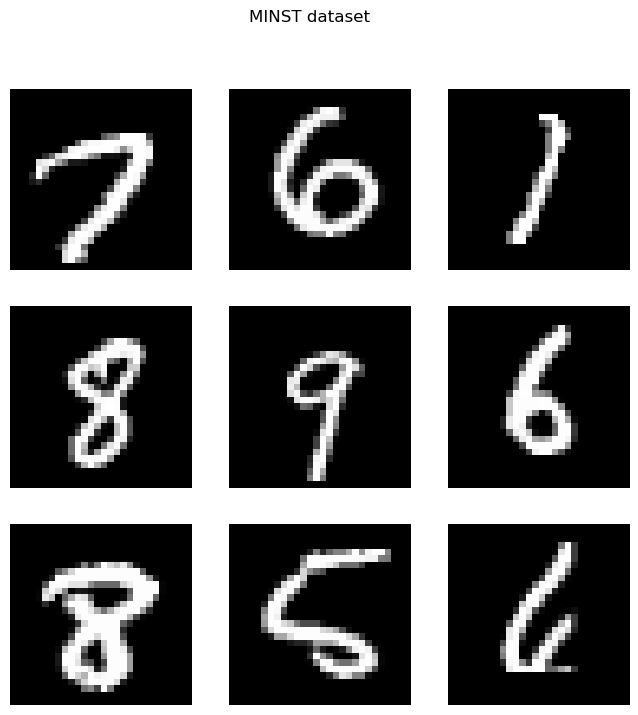

In [11]:
# just a quick plot to visualise the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(base_images), size=(1,)).item()
    img, label = base_images[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
figure.suptitle("MINST dataset")
plt.show()

# Noise addition

Use the gaussian reparameterization trick, we can write $q$ as
\begin{align*}
    q(x_t|x_0)=\mathcal{N}(x_t;\sqrt{\bar{\alpha}}x_0,(1-\hat{\alpha}_t)I)=\sqrt{\bar{\alpha}}x_0+\sqrt{(1-\hat{\alpha}_t)}\epsilon
\end{align*}
where $\epsilon\sim N(0,1)$. This also gives some mathematical intuition behind what is happening. We can for instance notice that as $t$ grows the original image decays further and further until we only have white noise. 

In [12]:
#define epsilon
# we have the dimension (1x28x28), from the definition
eps = torch.normal(0,1,(1,28,28))

# calculate alpha - this could be moved?
alphas = 1-betas

In [13]:
# helper function to add noise
# we could consider checking that image is a suitable type
def add_noise(input_image, t):
    alpha_bar = torch.prod(alphas[:t])
    output = torch.sqrt(alpha_bar)*input_image + torch.sqrt(1-alpha_bar)*eps
    return output

Text(0.5, 0.98, 'MINST dataset, additive noise visualisation')

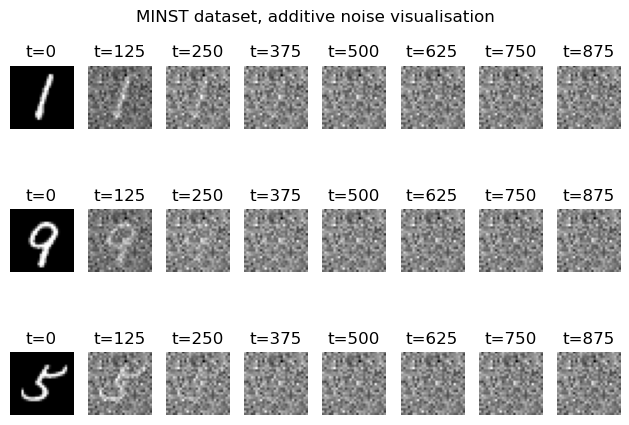

In [14]:
# allows us to test different time intervals - can be used for visualisation etc.
test_image, l = base_images[0]
x_t = add_noise(test_image, t=1000)

# basically we use the same value for steps and columns - but to make it clearer we do the assignment explicitly
# 6 steps for now
cols, rows = 8,3
steps = np.floor(T/cols)
time_int = torch.arange(0,T,step=steps,dtype=int)

fig, axs = plt.subplots(rows,cols)
for i in range(0,rows):
    sample_idx = torch.randint(len(base_images), size=(1,)).item()
    img, label = base_images[sample_idx]
    for j in range(0,cols):
        # add noise to image stepwise
        noised_image = add_noise(img, time_int[j])
        axs[i,j].imshow(noised_image.squeeze(),cmap="gray")
        axs[i,j].axis('off')
        axs[i,j].set_title(f't={time_int[j]}')
fig.tight_layout()
fig.suptitle("MINST dataset, additive noise visualisation")


The plot does seem to suggest that mabye a lower bound on T for a smaller image could work? Or the noise schedule needs to be adjusted - as we get a lot of noise very fast here. This might affect the results we get. 

# U-net construction, training

The rough idea here is to use the original model discussed in XX and with some adaptations for the smaller image size. We do not use the same dataset as in the 'original' diffusion paper, meaning that dimensions will slightly differ. We will however use the same channel specifications (outlined in Appendix B), i.e.
(32,64,128)

We want to specify the channels flexibly in the code so that we can adapt the same 'fundamental' structure to larger U-nets should we want to try to generate larger images or if it shows that the current channel specifications are lacking. 

In [62]:
# check if we have mps, cuda avaliable
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [35]:
"""
The 'standard' implementation of the time embeddings. 
[todo]: add references here, add passthrough to device
Inputs:
'dim': the time embedding dimensions.
'time' the time point to be encoded.
"""
# implement as a module to allow for more flexible use in the actual network.
class CreateTimeEmbedding(nn.Module):
    """Initialise for specific time dimension. Takes dim as input."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # pass to necessary variables to allow for processing on eg. cuda or MPS
        # device = time.device

        half_dim = self.dim//2
        embeddings = math.log(10000)/(half_dim-1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [52]:
"""Test code for figuring out how we get the right dimensions for the time embeddings."""
time_embed_dim = 32
time_embed = CreateTimeEmbedding(time_embed_dim)

# just use the first one 
test_image, label = base_images[0]

time_embedding = time_embed(torch.tensor([100]))
display(time_embedding)

# get dimensions 
display(time_embedding.size())
display(test_image.size())
linear_test = nn.Linear(32,3)
time_embedding = linear_test(time_embedding)
display(time_embedding.size())
time_embedding = time_embedding[(...,)+(None, )*2]
display(time_embedding.size())
display(time_embedding)

tensor([[-0.5064, -0.6517, -0.8480, -0.1405,  0.7498, -0.9975,  0.5889,  0.9777,
          0.6711,  0.3877,  0.2138,  0.1163,  0.0631,  0.0341,  0.0185,  0.0100,
          0.8623, -0.7584, -0.5301, -0.9901, -0.6616, -0.0707, -0.8082,  0.2099,
          0.7414,  0.9218,  0.9769,  0.9932,  0.9980,  0.9994,  0.9998,  0.9999]])

torch.Size([1, 32])

torch.Size([1, 28, 28])

torch.Size([1, 3])

torch.Size([1, 3, 1, 1])

tensor([[[[0.1357]],

         [[0.1527]],

         [[0.2689]]]], grad_fn=<UnsqueezeBackward0>)

In [64]:


#Define model
# We will use the model introduced in XX and we will use YY 
# note that we dont need the very final piece, as we want an image in the same 'form' as the input image to compare

# rough architecture
# set the dimensions in the code, this allows for us to be a bit more flexible, i.e 
# (32,64,128) - this will be verified with the original paper - since we set the channels in 
# code, we can easily expand the network further for even larger images.

# TODO: consider setting switch for creating the connections 

class UnetBlock(nn.Module):
    """
    Code for the convolution blocks described in the U-Net architecture. 
    Inputs:
    in_channels: number of input channels.
    out_channels: number of output channels.
    time_dim: dimension of time encoding. 
    up: upsampling mode if true. 
    """
    def __init__(self, in_channels, out_channels,time_dim,up=False):
        super().__init__()
        # operator to change dimension to fit out_channels. 
        # Basically: the idea is we want to make the time embeddings broadcastable.
        # This linear transform first gives us the right number of 'out' channels. 
        self.time_change_dim = nn.Linear(time_dim, out_channels)
        # first conv stack
        if up == True:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels*2, out_channels, 3,1),
                # since we concat the inputs we need to note the change in dimension
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            )
            # check this
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 2,1,1)
            # self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4,2,1)
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3,1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            )
            # check this
            # self.transform = nn.Conv2d(out_channels,out_channels,4,2,1)
            self.transform = nn.MaxPool2d(out_channels, out_channels, 2,1,1)
        # second conv stack
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        # Since we use only this once, for time
        self.relu = nn.ReLU()    
    """
    The forward function. We apply the convolution operators etc. on the input.
    As specified in the U-net architecture. We also apply time embedding.
    Inputs:
    x: the image being transformed.
    t: embedded time
    Outputs:
    out: output from passing through
    out_connection: output for implementing connections to the network.
    """
    def forward(self, x,t):
        # Run it through relu to give more weights for the model to train
        time_embedding = self.relu(self.time_change_dim(t))
        # We then expand t to the 'right' form by using the following code:
        # This basically allows us to broadcast the time embedding over the input x.
        time_embedding = time_embedding[(...,)+(None, )*2]

        h = self.conv1(x)
        # add time
        h,out_connection = h+time_embedding
        # second pass
        h = self.conv2(h)
        # apply the transform
        out = self.transform(h)
        return out, out_connection

class uNet(nn.Module):
    # Basically since we always use a 3x3 kernel we can do this:
    #conv_stack = lambda in_channel, out_channel : nn.Sequential(
    #    nn.Conv2d(in_channel, out_channel, 3)
    #)
    def __init__(self):
        super().__init__()
        # Channels - could be adjusted in the future via *args, *kwargs
        # basically if we have colour images or not.
        image_channels = 1
        out_dim = 1

        down_channels = (32, 64, 128)
        up_channels = (128,64,32)
        time_embed_dim = 32
        
        # look into this a bit closer - figure out how it exactly functions
        self.time_stack = nn.Sequential(
            CreateTimeEmbedding(time_embed_dim),
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.ReLU()
        )

        self.initial_conv = nn.Conv2d(image_channels, down_channels[0],3,padding=1)

        self.downs = nn.ModuleList([UnetBlock(down_channels[i],down_channels[i+1],time_embed_dim)
                                  for i in range(len(down_channels)-1)])

        self.ups = nn.ModuleList([UnetBlock(up_channels[i],up_channels[i+1],time_embed_dim,up=True)
                                  for i in range(len(up_channels)-1)])

        self.output_conv = nn.Conv2d(up_channels[-1],out_dim,1)

        ####
        # OLD CODE
        ####
        # We can just use this, as maxpool/unpool only requires the window size.
        #self.max_pool = nn.MaxPool2d(2)
        # fix this
        #self.up_conv = nn.ConvTranspose2d(2)

    """Inputs: 
        x: input image, noised
        time: time corresponding to noise level"""
    def forward(self,x,time):
        # NEW we pass time to the block.
        t = self.time_stack(time)
        x = self.initial_conv(x)

        # for storing the residuals
        residuals = []
        
        for down in self.downs:
            x,residual = down(x,t)
            residuals.append(residual)
        for up in self.ups:
            residual_connection = residuals.pop()
            x = torch.cat((x,residual_connection),dim=1)
            x = up(x,t)

        return self.output_conv(x)
model = uNet().to(device)

display(model)


uNet(
  (time_stack): Sequential(
    (0): CreateTimeEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): UnetBlock(
      (time_change_dim): Linear(in_features=32, out_features=64, bias=True)
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (transform): MaxPool2d(kernel_size=64, stride=64, padding=2, dilation=1, ceil_mode=False)
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): UnetBlock(
      (time_change_dim): Linear(in_features=32, out_features=128, bias=True)
      (conv

We use MSE as the loss function - this boils down to basically the following fact: when we look at the loss function derived in the 2020 paper on denoising diffusion models (in paricular page 3), it can be observed that the final loss function looks a lot like the MSE. There is more in-depth research on this but this was more a personal motivation for (why) we can simply use the MSE. 

In [ ]:
# training parameters
epochs = 100
batches = 64

In [ ]:
# Training function using algorithm detailed in 2020 paper.

def train(dataloader, model, loss_fn, optimizer):
    pass 


In [ ]:

# loss function, optimiser
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


